In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib

from skglm import GeneralizedLinearEstimator
from skglm.penalties import L1, WeightedL1, MCPenalty
from skglm.datafits import Quadratic

from utils import comp_sharpe_ratio, comp_sortion_ratio, comp_MDD, comp_calmar_ratio
matplotlib.rcParams.update({'font.size': 16})

In [8]:
## Extract the companies ticker in Nasdaq-100
company_table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
print(company_table[0])
stock_list = company_table['Symbol'].to_list()

    Symbol              Security             GICS Sector  \
0      MMM                    3M             Industrials   
1      AOS           A. O. Smith             Industrials   
2      ABT                Abbott             Health Care   
3     ABBV                AbbVie             Health Care   
4      ACN             Accenture  Information Technology   
..     ...                   ...                     ...   
498    YUM           Yum! Brands  Consumer Discretionary   
499   ZBRA    Zebra Technologies  Information Technology   
500    ZBH         Zimmer Biomet             Health Care   
501   ZION  Zions Bancorporation              Financials   
502    ZTS                Zoetis             Health Care   

                      GICS Sub-Industry    Headquarters Location  Date added  \
0              Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1                     Building Products     Milwaukee, Wisconsin  2017-07-26   
2                 Health Care Equipment

TypeError: list indices must be integers or slices, not str

In [3]:
start_time = '2017-01-01'
end_time = '2022-12-31'

stock_data = []
for idx in stock_list:
    temp_data = yf.download(idx, start=start_time, end=end_time)
    data_ = pd.DataFrame()
    data_[idx] = temp_data['Adj Close']
    stock_data.append(data_)

stock_data = pd.concat(stock_data, axis=1)
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format="%d-%m-%Y").dt.date
stock_data = stock_data.set_index('Date')

stock_data = stock_data.fillna(method='ffill')
stock_data = stock_data.fillna(method='bfill')

stock_pct = stock_data.pct_change()[1:]
stock_idx = stock_pct.index

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
nasdaq_data =  yf.download('^NDX', start=start_time, end=end_time)['Adj Close']

nasdaq_data = nasdaq_data.fillna(method='ffill')
nasdaq_data = nasdaq_data.fillna(method='bfill')

nasdaq_pct = nasdaq_data.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [5]:
train_widnow, test_window = 100, 30
X = stock_pct.values * 100
y = nasdaq_pct.values * 100

T = X.shape[0]
indx = stock_idx[train_widnow + test_window-1:]

In [6]:
### Lasso algorithms
y_gt_list = []
y_est_list = []
model = GeneralizedLinearEstimator(Quadratic(), L1(alpha=0.7, positive=True))
for i in range(train_widnow, T - test_window, test_window):
    X_train = X[i - train_widnow:i, :]
    y_train = y[i - train_widnow:i]

    X_test = X[i:i + test_window, :]
    y_test = y[i:i + test_window]

    model.fit(X_train, y_train)
    w_est = model.coef_
    w_est = w_est / np.sum(w_est)
    y_est = X_test.dot(w_est)

    y_est_list.append(y_est)
    y_gt_list.append(y_test)
        
y_res_lasso = np.concatenate(y_est_list)
y_gt = np.concatenate(y_gt_list)

In [7]:
### Weighted Lasso algorithms
y_gt_list = []
y_est_list = []

S = (1/T) * X.T.dot(X)
eigen_vals, eigen_vects = np.linalg.eig(S)
eigen_vals = eigen_vals / np.sum(eigen_vals)

model = GeneralizedLinearEstimator(Quadratic(), WeightedL1(alpha=10, weights=eigen_vals, positive=True))
for i in range(train_widnow, T - test_window, test_window):
    X_train = X[i - train_widnow:i, :]
    y_train = y[i - train_widnow:i]

    X_test = X[i:i + test_window, :]
    y_test = y[i:i + test_window]

    model.fit(X_train, y_train)
    w_est = model.coef_
    w_est = w_est / np.sum(w_est)
    y_est = X_test.dot(w_est)

    y_est_list.append(y_est)
        
y_res_weightedlasso = np.concatenate(y_est_list)

In [8]:
### MCPenalty

def loss_fn(X, w, b):
    '''
    params:
        X: np.array, [T, N]
        w: np.array, [N,]
        b: np.array, [T ]

    return:
        obj: np.array, [T, 1]
    '''
        
    T = X.shape[0]
    
#     print(X.shape, w.shape, b.shape)
    
    loss = cp.norm(X @ w - b, 2) ** 2
    obj = loss / T
    
    return obj

def solve_quadratic_program(X, y):
    '''
    params:
        X: np.array, [T, N]
        y: np.array, [T, 1]
        w: np.array, [N, 1]
        b: np.array, [T, 1]
    
    return:
        w: np.array, [N, 1]
    '''
    
    
    
    T, N = X.shape
    
    w = cp.Variable(N)
    one_vec = np.ones(N)
    
    h = np.ones(1)
    b = np.zeros(N)
    
    problem = cp.Problem(cp.Minimize(loss_fn(X, w, y)), 
                        [one_vec @ w == h,
                         w >= b])
    problem.solve()
    res = w.value
    
    return res

y_gt_list = []
y_est_list = []

model = GeneralizedLinearEstimator(Quadratic(), MCPenalty(alpha=0.5, gamma=1.1))
for i in range(train_widnow, T - test_window, test_window):
    X_train = X[i - train_widnow:i, :]
    y_train = y[i - train_widnow:i]

    X_test = X[i:i + test_window, :]
    y_test = y[i:i + test_window]

    model.fit(X_train, y_train)
    w_est_init = model.coef_

    w_indxs = np.argwhere(w_est_init > 0).flatten()
    w_est = np.zeros(w_est_init.shape[0])

    X_new = X_train[:, w_indxs].squeeze()
    w_est_ls = solve_quadratic_program(X_new, y_train)
    w_est[w_indxs] = w_est_ls

    y_est = X_test.dot(w_est)

    y_est_list.append(y_est)
        
y_res_MCPenalty = np.concatenate(y_est_list)

In [9]:
# Using the LAIT algorithm

def comp_rho_p(x, p=0.5):
    '''
    params:
        x : np.array, [N,]
    return:
        res: np.array, [N, N], digonal matix
    '''
    
    N = x.shape[0]
    
    c1 = p + np.abs(x)
    c2 = np.log(1 + 1/p)
    res = 1 / (c1 * c2)
    res = np.diag(res)
    return res

def loss_fn(X, w, b):
    '''
    params:
        X: np.array, [T, N]
        w: np.array, [N,]
        b: np.array, [T ]

    return:
        obj: np.array, [T, 1]
    '''
        
    T = X.shape[0]
    
#     print(X.shape, w.shape, b.shape)
    
    loss = cp.norm(X @ w - b, 2) ** 2
    obj = loss / T
    
    return obj

def reg_fn(w, D, lambd=0.5):
    
    '''
    params:
        w: np.array, [N,]
        lambd: hyper-paramer
    return:
        w: np.array, [N, 1]
    '''
    
    l1 = cp.norm1(D @ w)
    obj = lambd * l1
    
    return obj

def objective_fn(X, w, b, D, lambd):
    
    l2_term = loss_fn(X, w, b)
    l1_term = reg_fn(w, D, lambd)
    
    return l2_term + l1_term

def solve_quadratic_program(X, x_true, D, lambd):
    '''
    params:
        X: np.array, [T, N]
        w: np.array, [N, 1]
        b: np.array, [T, 1]
        D: np.array, [N, N]
    
    return:
        w: np.array, [N, 1]
    '''
    
    
    
    T, N = X.shape
    
    w = cp.Variable(N)
    one_vec = np.ones(N)
    
    h = np.ones(1)
    b = np.zeros(N)
    lambd_ = cp.Parameter(nonneg=True)
    lambd_.value = lambd
    
    problem = cp.Problem(cp.Minimize(objective_fn(X, w, x_true, D, lambd)), 
                        [one_vec @ w == h,
                         w >= b])
    problem.solve()
    res = w.value
    
    return res

def LAIT_algo_optim(X, y, num_iter=50, p=0.5, lambd=0.0002):
    '''
    params:
        X: np.array, matrix of stock returns, size: [T, N], where N: number of stocks, T: the number of timesteps
        y: np.array, matrix of index returns, size: [T, ]
    
    return:
        w_star: [N, ], weights of stocks
    '''
    
    N = X.shape[1]
    w_init = np.random.randn(N)
    w_init = w_init / np.sum(w_init)
    
    w_k = w_init
    for i in range(0, num_iter):
        D = comp_rho_p(w_k, p=p)
        w_k = solve_quadratic_program(X, y, D, lambd=lambd)
        
    return w_k

In [10]:
num_iter = 50
p = 0.6
lambd = 0.06

y_gt_list = []
y_est_list = []

for i in range(train_widnow, T - test_window, test_window):
    X_train = X[i - train_widnow:i, :]
    y_train = y[i - train_widnow:i]

    X_test = X[i:i + test_window, :]
    y_test = y[i:i + test_window]

    w_est = LAIT_algo_optim(X_train, y_train, num_iter = num_iter, p = p, lambd = lambd)
    w_est = w_est / np.sum(w_est)
    y_est = X_test.dot(w_est)    

    y_est_list.append(y_est)
        
y_res_LAIT = np.concatenate(y_est_list)

/home/gwan/anaconda3/envs/py38quant/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [11]:
def comp_measures(X, N=256, rf=0.00, methods='OLS'):
    
    sharpe_ratio = comp_sharpe_ratio(X, N, rf)
    sortion_ratio = comp_sortion_ratio(X, N, rf)
    maxDD, maxDDD, i = comp_MDD(X)
    calmer_ratio = comp_calmar_ratio(X)

    print("the method {}".format(methods))
    print("sharpe ratio is {:.4f}, sortion ratio is {:.4f}, the calmer ratio is {:.4f}".format(sharpe_ratio, 
                                                                                               sortion_ratio, 
                                                                                               calmer_ratio)) 
    print("the maximum drawdown is {:.4f}, the duration of maximum drawdown is {:.4f}\n".format(maxDD, maxDDD))

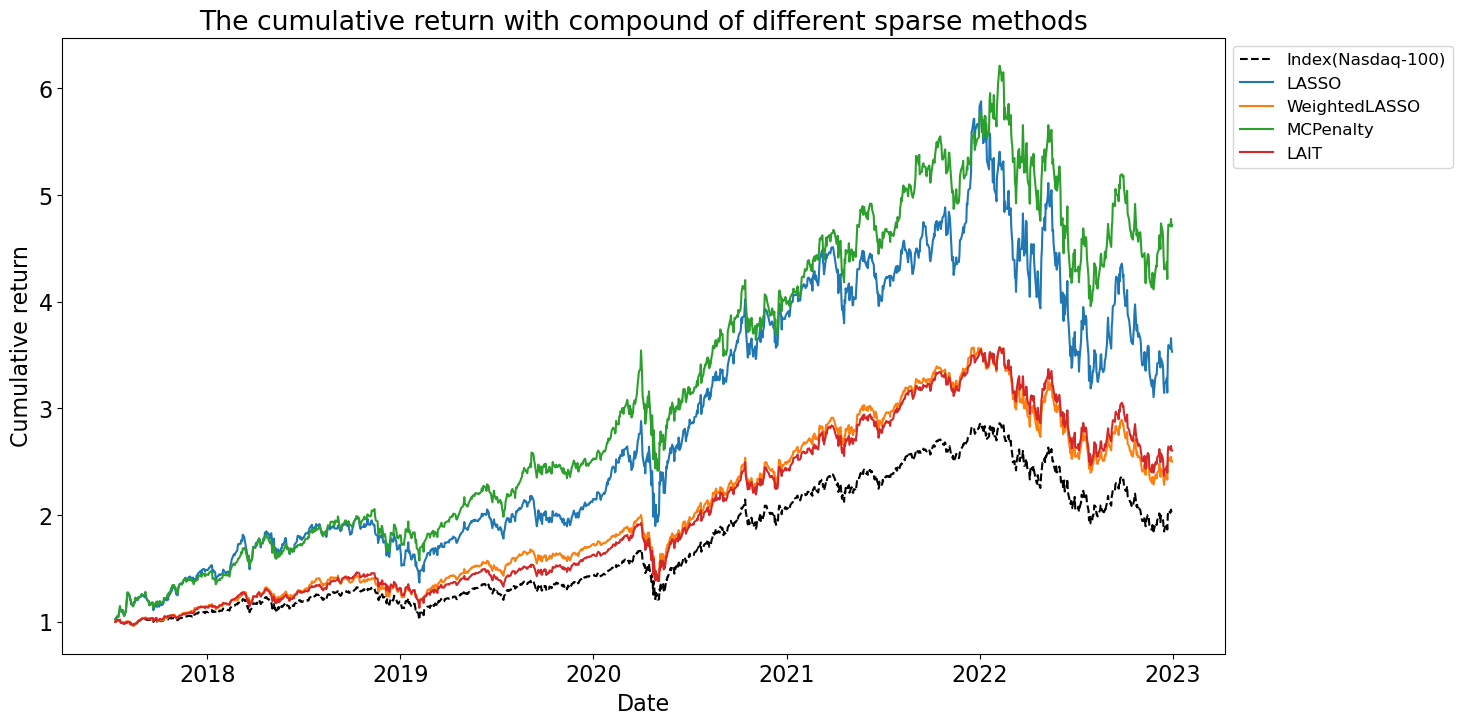

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(indx, np.cumprod((1+y_gt/100)), '--', color='black', label = 'Index(Nasdaq-100)')
plt.plot(indx, np.cumprod((1+y_res_lasso/100)), label='LASSO')
plt.plot(indx, np.cumprod((1+y_res_weightedlasso/100)), label='WeightedLASSO')
plt.plot(indx, np.cumprod((1+y_res_MCPenalty/100)), label='MCPenalty')
plt.plot(indx, np.cumprod((1+y_res_LAIT/100)), label='LAIT')
plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of different sparse methods")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left',fontsize=12)

In [13]:
comp_measures(y_gt/100, methods='GT')
comp_measures(y_res_lasso/100, methods='LASSO')
comp_measures(y_res_weightedlasso/100, methods="WeightedLASSO")
comp_measures(y_res_MCPenalty/100, methods='MCPenalty')
comp_measures(y_res_LAIT/100, methods='LAIT')

the method GT
sharpe ratio is 0.6384, sortion ratio is 0.8027, the calmer ratio is 0.6169
the maximum drawdown is -0.2631, the duration of maximum drawdown is 250.0000

the method LASSO
sharpe ratio is 0.8055, sortion ratio is 1.1078, the calmer ratio is 0.7579
the maximum drawdown is -0.4032, the duration of maximum drawdown is 250.0000

the method WeightedLASSO
sharpe ratio is 0.7692, sortion ratio is 0.9768, the calmer ratio is 0.7272
the maximum drawdown is -0.2824, the duration of maximum drawdown is 226.0000

the method MCPenalty
sharpe ratio is 1.0422, sortion ratio is 1.4415, the calmer ratio is 1.0899
the maximum drawdown is -0.3123, the duration of maximum drawdown is 226.0000

the method LAIT
sharpe ratio is 0.8184, sortion ratio is 1.0352, the calmer ratio is 0.7982
the maximum drawdown is -0.2632, the duration of maximum drawdown is 226.0000

